# Imputing Missing Values

In [1]:
# %%time
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

from sklearn.ensemble import ExtraTreesRegressor
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

/Users/sametmarasli/anaconda3/envs/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Functions

In [2]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "mse",
        "num_leaves" : 20,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], 
                      early_stopping_rounds=100, verbose_eval=200, 
                      evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [45]:
def checking_distributions(feature):
    print('\n\nRatio of missing values between test and train')
    print('train')
    print(train_df[feature].isnull().sum()/train_df.shape[0])
    print('test')
    print(test_df[feature].isnull().sum()/test_df.shape[0])

    print('\nDistribution of missing values between test and train')

    print('\ntrain_df distribution of {} '.format(feature))
    print(stats.describe(np.log1p(train_df[feature].dropna())))
    print('\ntest_df distribution of {} '.format(feature))
    print(stats.describe(np.log1p(test_df[feature].dropna())))

#     print(train_df.groupby(['renewal'])[feature].count())

#     print(train_df[train_df[feature].isnull()].groupby('renewal')['renewal'].count())

    print('\nThe ratio of target value considering null values')
    print('without null values')
    print(train_df[~train_df[feature].isnull()]['renewal'].mean())
    print('only null values')
    print(train_df[train_df[feature].isnull()]['renewal'].mean())

# Import Data

In [4]:
train_df = pd.read_csv('./data/train_ZoGVYWq.csv')
test_df = pd.read_csv('./data/test_66516Ee.csv')
col = [c for c in train_df.columns if c not in ['id','renewal']]
print(len(col))

11


In [5]:
CATEGORICAL_COLUMNS = ["sourcing_channel",
                      'residence_area_type']

CONTINUOUS_COLUMNS = ['perc_premium_paid_by_cash_credit',
                      'age_in_days',
                      'Income',
                     'application_underwriting_score',
                     'premium']

DISCRETE_COLUMNS = ['Count_3-6_months_late',
                    'Count_6-12_months_late',
                   'Count_more_than_12_months_late',
                   'no_of_premiums_paid']

# DUMMY_COLUMNS = ["Medical_Keyword_{}".format(i) for i in range(1, 48)]

In [6]:
categorical_data = pd.concat([train_df[CATEGORICAL_COLUMNS], test_df[CATEGORICAL_COLUMNS]])
continuous_data = pd.concat([train_df[CONTINUOUS_COLUMNS], test_df[CONTINUOUS_COLUMNS]])
discrete_data = pd.concat([train_df[DISCRETE_COLUMNS], test_df[DISCRETE_COLUMNS]])

categorical_data_bin = categorical_data.applymap(str)  # need to conver into strings to appyly get_dummies
categorical_data_bin = pd.get_dummies(categorical_data_bin, drop_first=True)

total_df = pd.concat([continuous_data,discrete_data,categorical_data_bin],axis=1).reset_index(drop=True)

In [7]:
colsToImpute = []
for i,j in total_df.isnull().sum().reset_index().values:
    if j>0:colsToImpute.append(i)

In [8]:
print('\ntotal_df missing values')
print(total_df[colsToImpute].isnull().sum(),)
print('\ntrain_df missing values')
print(train_df[colsToImpute].isnull().sum(),)
print('\ntest_df missing values')
print(test_df[colsToImpute].isnull().sum())


total_df missing values
application_underwriting_score    4297
Count_3-6_months_late              128
Count_6-12_months_late             128
Count_more_than_12_months_late     128
dtype: int64

train_df missing values
application_underwriting_score    2974
Count_3-6_months_late               97
Count_6-12_months_late              97
Count_more_than_12_months_late      97
dtype: int64

test_df missing values
application_underwriting_score    1323
Count_3-6_months_late               31
Count_6-12_months_late              31
Count_more_than_12_months_late      31
dtype: int64


# Checking Distributions of Features to Impute

#### application_underwriting_score

In [46]:
print(colsToImpute[0])
checking_distributions(colsToImpute[0])

application_underwriting_score


Ratio of missing values between test and train
train
0.03724343481146607
test
0.03865708274894811

Distribution of missing values between test and train

train_df distribution of application_underwriting_score 
DescribeResult(nobs=76879, minmax=(4.531523645819793, 4.614030814420288), mean=4.605815159262258, variance=5.581825302948168e-05, skewness=-2.852942673891252, kurtosis=14.973687856691072)

test_df distribution of application_underwriting_score 
DescribeResult(nobs=32901, minmax=(4.531523645819793, 4.614030814420288), mean=4.605761038664235, variance=5.625736701534689e-05, skewness=-2.738558830597685, kurtosis=13.584874046677882)

The ratio of target value considering null values
without null values
0.9375902392070656
only null values
0.9327505043712172


#### Count_3-6_months_late

In [47]:
print(colsToImpute[1])
checking_distributions(colsToImpute[1])

Count_3-6_months_late


Ratio of missing values between test and train
train
0.0012147320701789538
test
0.0009057971014492754

Distribution of missing values between test and train

train_df distribution of Count_3-6_months_late 
DescribeResult(nobs=79756, minmax=(0.0, 2.6390573296152584), mean=0.1422212262977352, variance=0.11892829067312924, skewness=2.4611254125431885, kurtosis=5.6325214361521265)

test_df distribution of Count_3-6_months_late 
DescribeResult(nobs=34193, minmax=(0.0, 2.5649493574615367), mean=0.1364877009808167, variance=0.11451018678401678, skewness=2.5575342855896017, kurtosis=6.315616265524319)

The ratio of target value considering null values
without null values
0.9380861627965295
only null values
0.38144329896907214


#### Count_6-12_months_late

In [48]:
print(colsToImpute[2])
checking_distributions(colsToImpute[2])

Count_6-12_months_late


Ratio of missing values between test and train
train
0.0012147320701789538
test
0.0009057971014492754

Distribution of missing values between test and train

train_df distribution of Count_6-12_months_late 
DescribeResult(nobs=79756, minmax=(0.0, 2.8903717578961645), mean=0.04359826771661013, variance=0.04192824911002299, skewness=5.309497700543187, kurtosis=31.702913451210534)

test_df distribution of Count_6-12_months_late 
DescribeResult(nobs=34193, minmax=(0.0, 2.3978952727983707), mean=0.044095840309452065, variance=0.04364006348208998, skewness=5.4032647946022205, kurtosis=32.796682754859944)

The ratio of target value considering null values
without null values
0.9380861627965295
only null values
0.38144329896907214


#### Count_more_than_12_months_late

In [12]:
print(colsToImpute[3])
checking_distributions(colsToImpute[3])

Count_more_than_12_months_late


Ratio of missing values between test and train
0.0012147320701789538
0.0009057971014492754

Distribution of missing values between test and train

train_df distribution of Count_more_than_12_months_late 
DescribeResult(nobs=79756, minmax=(0.0, 2.4849066497880004), mean=0.037093727813130695, variance=0.03057542145897063, skewness=5.083446355992594, kurtosis=28.059436400410664)

test_df distribution of Count_more_than_12_months_late 
DescribeResult(nobs=34193, minmax=(0.0, 2.0794415416798357), mean=0.03592362296207725, variance=0.029643384948691277, skewness=5.177031354120932, kurtosis=29.186673097906578)

The ratio of target value considering null values
0.9380861627965295
0.38144329896907214


# Imputing Missing Values

In [13]:
train_df_2 = total_df.iloc[:train_df.shape[0],:]

train_df_2 = train_df_2.dropna(axis=0)

train_df_2_renewal = train_df[['renewal']].loc[train_df_2.index]

train_df_2 = pd.concat([train_df_2,train_df_2_renewal],axis=1)

## 'application_underwriting_score'

In [14]:
y = train_df_2['application_underwriting_score']

In [15]:
X = train_df_2.drop(colsToImpute,axis=1)

In [16]:
X_1, X_2, y_1, y_2 = model_selection.train_test_split(X, y, test_size=0.25, random_state=99)

train_X = X_1.reset_index(drop=True)
test_X = X_2.reset_index(drop=True)
train_y = y_1.values

In [17]:
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=2017)
pred_test_full = 0

for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
#     print(dev_X.shape), print(dev_y.shape), print(val_X.shape), print(val_y.shape), print(test_X.shape)
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
    
pred_test_full /= 5.

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.406504
[400]	valid_0's l2: 0.379661
[600]	valid_0's l2: 0.372755
[800]	valid_0's l2: 0.370809
[1000]	valid_0's l2: 0.370171
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.407638
[400]	valid_0's l2: 0.378457
[600]	valid_0's l2: 0.371606
[800]	valid_0's l2: 0.369869
[1000]	valid_0's l2: 0.369534
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.397658
[400]	valid_0's l2: 0.371235
[600]	valid_0's l2: 0.365908
[800]	valid_0's l2: 0.364763
Early stopping, best iteration is:
[815]	valid_0's l2: 0.364745


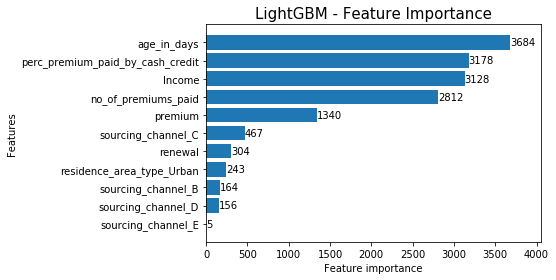

In [18]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(6,4))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [19]:
print(mean_squared_error(model.predict(X_1),y_1))
print(mean_squared_error(model.predict(X_2),y_2))

0.3482728997454497
0.3613464973334556


In [20]:
to_impute = total_df[total_df['application_underwriting_score'].isnull()].drop(colsToImpute,axis=1)

idx_to_impute = total_df.loc[total_df['application_underwriting_score'].isnull()].index.tolist()

imputed_total_df = total_df.copy()

imputed_total_df.loc[idx_to_impute,'application_underwriting_score'] = model.predict(to_impute)

## 'Count_3-6_months_late'

In [23]:
y = train_df_2['Count_3-6_months_late']

In [24]:
X = train_df_2.drop(colsToImpute,axis=1)

In [25]:
X_1, X_2, y_1, y_2 = model_selection.train_test_split(X, y, test_size=0.25, random_state=99)

train_X = X_1.reset_index(drop=True)
test_X = X_2.reset_index(drop=True)
train_y = y_1.values

In [26]:
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=2017)
pred_test_full = 0

for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
#     print(dev_X.shape), print(dev_y.shape), print(val_X.shape), print(val_y.shape), print(test_X.shape)
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
    
pred_test_full /= 5.

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.434379
[400]	valid_0's l2: 0.429157
Early stopping, best iteration is:
[463]	valid_0's l2: 0.428968
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.434802
[400]	valid_0's l2: 0.429739
Early stopping, best iteration is:
[496]	valid_0's l2: 0.429552
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.436166
[400]	valid_0's l2: 0.43232
Early stopping, best iteration is:
[401]	valid_0's l2: 0.432312


In [27]:
print(mean_squared_error(model.predict(X_1),y_1))
print(mean_squared_error(model.predict(X_2),y_2))

0.41509995163914004
0.448957301955007


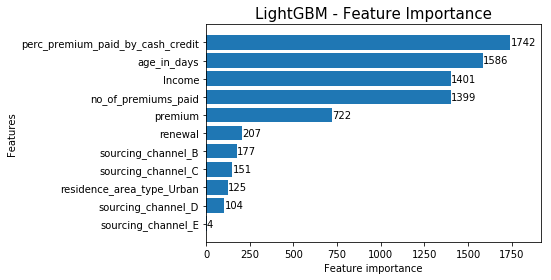

In [28]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(6,4))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [29]:
to_impute = total_df[total_df['Count_3-6_months_late'].isnull()].drop(colsToImpute,axis=1)

idx_to_impute = total_df.loc[total_df['Count_3-6_months_late'].isnull()].index.tolist()

imputed_total_df.loc[idx_to_impute,'Count_3-6_months_late'] = model.predict(to_impute)

## 'Count_6-12_months_late'

In [30]:
y = train_df_2['Count_6-12_months_late']

In [31]:
X = train_df_2.drop(colsToImpute,axis=1)

In [32]:
X_1, X_2, y_1, y_2 = model_selection.train_test_split(X, y, test_size=0.25, random_state=99)

train_X = X_1.reset_index(drop=True)
test_X = X_2.reset_index(drop=True)
train_y = y_1.values

In [33]:
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=2017)
pred_test_full = 0

for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
#     print(dev_X.shape), print(dev_y.shape), print(val_X.shape), print(val_y.shape), print(test_X.shape)
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
    
pred_test_full /= 5.

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.155907
[400]	valid_0's l2: 0.15483
Early stopping, best iteration is:
[387]	valid_0's l2: 0.154809
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.154145
[400]	valid_0's l2: 0.153015
Early stopping, best iteration is:
[345]	valid_0's l2: 0.152829
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.173647
[400]	valid_0's l2: 0.171882
Early stopping, best iteration is:
[443]	valid_0's l2: 0.171844


In [34]:
print(mean_squared_error(model.predict(X_1),y_1))
print(mean_squared_error(model.predict(X_2),y_2))

0.14975335382427607
0.16232402294613307


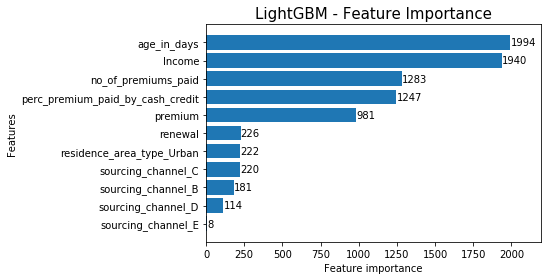

In [35]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(6,4))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [36]:
to_impute = total_df[total_df['Count_6-12_months_late'].isnull()].drop(colsToImpute,axis=1)

idx_to_impute = total_df.loc[total_df['Count_6-12_months_late'].isnull()].index.tolist()

imputed_total_df.loc[idx_to_impute,'Count_6-12_months_late'] = model.predict(to_impute)

## 'Count_more_than_12_months_late'

In [38]:
y = train_df_2['Count_more_than_12_months_late']

X = train_df_2.drop(colsToImpute,axis=1)

In [39]:
X_1, X_2, y_1, y_2 = model_selection.train_test_split(X, y, test_size=0.25, random_state=99)

train_X = X_1.reset_index(drop=True)
test_X = X_2.reset_index(drop=True)
train_y = y_1.values

In [40]:
kf = model_selection.KFold(n_splits=3, shuffle=True, random_state=2017)
pred_test_full = 0

for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
#     print(dev_X.shape), print(dev_y.shape), print(val_X.shape), print(val_y.shape), print(test_X.shape)
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
    
pred_test_full /= 5.

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.0886873
[400]	valid_0's l2: 0.0883049
Early stopping, best iteration is:
[343]	valid_0's l2: 0.0882704
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.0838047
[400]	valid_0's l2: 0.0831895
Early stopping, best iteration is:
[389]	valid_0's l2: 0.0831781
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's l2: 0.105227
[400]	valid_0's l2: 0.104655
Early stopping, best iteration is:
[372]	valid_0's l2: 0.104646


In [41]:
print(mean_squared_error(model.predict(X_1),y_1))
print(mean_squared_error(model.predict(X_2),y_2))

0.08842102890298058
0.09181988363021927


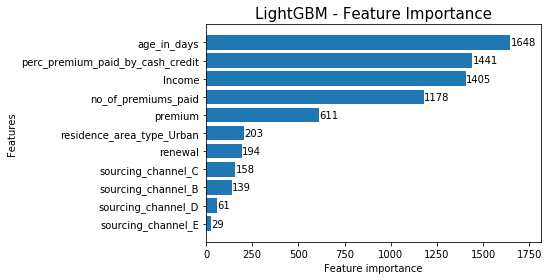

In [42]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(6,4))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [43]:
to_impute = total_df[total_df['Count_more_than_12_months_late'].isnull()].drop(colsToImpute,axis=1)

idx_to_impute = total_df.loc[total_df['Count_more_than_12_months_late'].isnull()].index.tolist()

imputed_total_df.loc[idx_to_impute,'Count_more_than_12_months_late'] = model.predict(to_impute)

# Store Imputed Dataset

In [49]:
imputed_total_df.to_pickle('./data/imputed_total_df.pkl')